In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def logprior(b, sigma2):
    return -np.log(sigma2)

def logistic(x, b):
    #x[0]: t
    #x[1]: h
    #x[2]: w
    theta = b[0] + x[0]*b[1] + x[1]*b[2] + x[2]*b[3] + x[3]*b[4]
    return 1.0/(1+np.exp(theta))

def linear(x, b):
    return b[0] + x[0]*b[1] + x[1]*b[2] + x[2]*b[3] + x[3]*b[4]

def loglikelihood(b, sigma2, x, y):
    n = len(x)
    return -n*np.log(sigma2) - 0.5*((y-logistic(x, b))**2).sum()/sigma2

def logpost(b, sigma2, x, y):
    return logprior(b, sigma2) + loglikelihood(b, sigma2, x, y)

In [5]:
# mcmc algorithm
def mcmc(b_init, sig2, x, y, N, burnin, be, sig2e):
    nFeat = len(b_init) - 1
    
    B = np.zeros((N,nFeat + 1))
    Sig2 = np.zeros(N)
    
    b_prev = b_init
    sig2_prev = sig2
    count = 0
    r = np.random.random(N)
    
    for i in xrange(N):
        b_star = np.random.normal(b_prev,be)

        sig2_star = abs(np.random.normal(sig2_prev, sig2e))
        
        p = logpost(b_star, sig2_star, x, y) - logpost(b_prev, sig2_prev, x, y)
        if np.log(r[i]) < p:
            b_prev = b_star
            sig2_prev = sig2_star
            count += 1
                           
        B[i] = b_prev
        Sig2[i] = sig2_prev
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return B, Sig2

In [6]:
def import_data():
    #import data and labels
    train_data = pd.read_csv('Waterpump-training-values.csv')
    train_labels = pd.read_csv('Waterpump-training-labels.csv')
    
    #separating dataset into training and testing for cross-validation - 90% into training
    test_idx = np.random.uniform(0, 1, len(train_data)) <= 0.9
    train = train_data[test_idx==True]
    trainLabels = train_labels[test_idx==True]
    test = train_data[test_idx==False]
    testLabels = train_labels[test_idx==False]
    
    return train, trainLabels, test, testLabels

In [31]:
def trainKNN(train, trainLabels):
    #trains classifier using longitude and latitude data
    features = ['longitude','latitude']
    trainLoc = train[features]
    hasLocIdx = trainLoc['longitude']>1
    trainLoc = trainLoc[hasLocIdx] #remove rows with empty location data
    trainLabelsLoc = trainLabels[hasLocIdx] #only keep labels corresponding to rows with non-empty location data
    
    #train kNN classifier
    nNeighbors = 60
    clf = KNeighborsClassifier(n_neighbors=nNeighbors,weights='distance',algorithm='auto')
    clf.fit(trainLoc[features], trainLabelsLoc['status_group'])
    
    return clf

def addKNNCol(data, clf):
    #uses trained classifier to add predictions for different classes
    features = ['longitude','latitude']
    probaPredict = clf.predict_proba(data[features])
    data['knnFunctional'] = probaPredict[:,0]
    data['knnNeedsRepair'] = probaPredict[:,1]
    data['knnNonFunctional'] = probaPredict[:,2]
    return data
    
def processAllData(train, trainLabels, test, testLabels):
    clf = trainKNN(train, trainLabels)
    addKNNCol(train, clf)
    addKNNCol(test, clf)
    
    train, nFeatures = processData(train)
    test, _ = processData(test)
    
    trainLabelsVect = pd.get_dummies(trainLabels['status_group'])
    trainLabelsVect['functionality'] = trainLabelsVect['functional'] + 0.5*trainLabelsVect['functional needs repair']
    
    return train, trainLabelsVect, test, testLabels, nFeatures

def processData(data):
    features = ['age', 'gps_height', 'knnFunctional', 'knnNonFunctional']
    nFeatures = len(features)
    data['age'] = 2015 - data['construction_year']
    return np.transpose(data[features].values), nFeatures

In [32]:
train, trainLabels, test, testLabels = import_data()
train, trainLabels, test, testLabels, nFeatures = processAllData(train, trainLabels, test, testLabels)

In [24]:
numBeta = nFeatures + 1  #1 more for the constant

In [ ]:
B, sig2= mcmc(np.zeros(numBeta), 0.1, train, trainLabels['functionality'], 10000, 0, 0.003, 0.003)

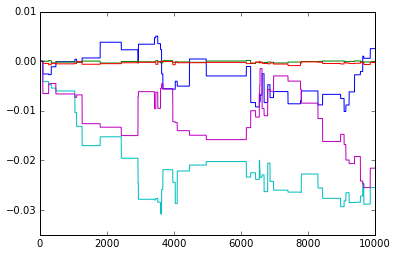

In [85]:
plt.plot(B[:,0])
plt.plot(B[:,1])
plt.plot(B[:,2])
plt.plot(B[:,3])
plt.plot(B[:,4])

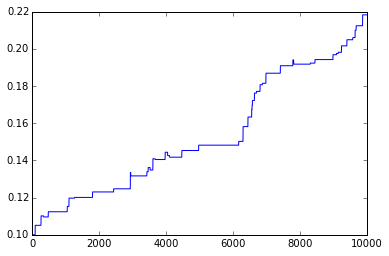

In [86]:
plt.plot(sig2)

In [87]:
b_final = B[-1,:]

In [41]:
b_final

array([ -6.99730186e-02,  -6.41988594e-04,  -2.34575944e-03,
         1.31367565e+00,   1.50905415e+00])

In [16]:
#transforming test data
features=['construction_year', 'gps_height']
testFeatures = test[features]
testFeatures['age'] = 2015 - testFeatures['construction_year']
testFeatures = testFeatures.drop('construction_year', 1)
probaPredictTest = clf.predict_proba(testFeatures)
kNNFunctionalTest = probaPredict[:,0]
knnNeedsRepairTest = probaPredict[:,1]
kNNnonFunctionalTest = probaPredict[:,2]
#TODO: get more meaningful data out of kNN algorithm?
xTest = np.vstack((trainFeatures['age'],trainFeatures['gps_height'],kNNFunctionalTest,kNNnonFunctionalTest))

In [91]:
#predictions - these are the continuous values, need to convert to labels
yPredict = logistic(xTest, b_final)

In [92]:
n = len(testLabels)
correct = 0.0
upBound =0.6
lowBound = 0.4
for yPred, label in zip(yPredict, testLabels['status_group']):
    if yPred >= upBound and label=='functional':
        correct += 1
    elif yPred <= lowBound and label == 'non functional':
        correct += 1
    elif yPred > lowBound and yPred < upBound and label == 'functional needs repair':
        correct += 1
print correct/n

0.17882785106


(array([  5338.,   5369.,   2459.,  23088.,   8755.,   6014.,   1690.,
           372.,    184.,    142.]),
 array([ 0.49947241,  0.52093854,  0.54240466,  0.56387079,  0.58533692,
         0.60680305,  0.62826918,  0.64973531,  0.67120144,  0.69266756,
         0.71413369]),
 <a list of 10 Patch objects>)

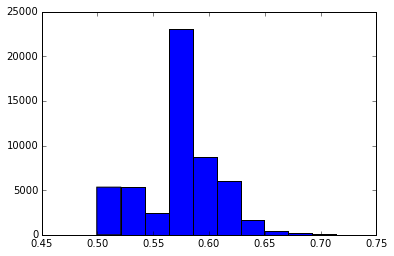

In [93]:
plt.hist(yPredict)

In [60]:
len(train_data)

59400